# Model performance

After training all SVMs, we assess model performance using precision and recall of both outcome classes.

### Importing packages

In [1]:
import numpy as np
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import shap

import pickle
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

### Functions to read files created by 2_modeltraining.py

In [6]:
def pretty_results(filenames, filepath='../results/models/'):
    reslist = []
    for index1, filename in enumerate(filenames):
        res = pd.read_pickle(filepath+filename+'.pkl')
        for index2, cr in enumerate(res):
            trainval = ['train', 'val'][index2 % 2]
            sex = ['M', 'M', 'F', 'F'][index2 % 4]
            reslist.append([index1+1, trainval, sex, cr['0']['precision'], cr['0']['recall'], cr['0']['support'],
                            cr['1']['precision'], cr['1']['recall'], cr['1']['support']])
    res = pd.DataFrame(reslist).set_axis(['nback', 'trainval', 'sex', 'ok_precision', 'ok_recall', 'ok_support',
                                          'low_precision', 'low_recall', 'low_support'], axis=1)
    return(res)
    
def get_scores(res_df):
    res_df['old_defrate'] = res_df['low_support'] / (res_df['low_support'] + res_df['ok_support'])
    res_df['new_defrate'] = 1 - res_df['ok_precision']
    res_df['missed_dons'] = 1 - res_df['ok_recall']
    res_df['prevented_defs'] = res_df['low_recall']
    res_df['missed_per_prev'] = (res_df['ok_support'] - res_df['ok_recall'] * res_df['ok_support']) / (res_df['low_support'] - (1 - res_df['ok_precision']) * res_df['ok_support'])
    
    res_df['old_def_n'] = res_df['low_support']
    res_df['new_def_n'] = round((1 - res_df['ok_precision']) * res_df['ok_support'])
    res_df['old_don_n'] = res_df['ok_support']
    res_df['new_don_n'] = res_df['ok_recall'] * res_df['ok_support']
    
    return(res_df)

def plot_precision_recall_all(res_df):
    pl_df = res_df.groupby(['sex', 'trainval'])

    fig, ax = plt.subplots(5, 2, figsize=(10, 12), sharey='row')

    for name, group in pl_df:
        y = 0 if name[0] == 'F' else 1
        off = -0.2 if name[1] == 'train' else 0.2
        ax[0, y].bar(group.nback + off, group.ok_precision, label=name[1], width=0.4, edgecolor='white')
        # ax[0, y].set_ylim(0.95, 1)
        ax[1, y].bar(group.nback + off, group.ok_recall, label=name[1], width=0.4, edgecolor='white')
        # ax[1, y].set_ylim(0.6, 0.85)
        
        ax[2, y].bar(group.nback + off, group.low_precision, label=name[1], width=0.4, edgecolor='white')
        # ax[2, y].set_ylim(0.95, 1)
        ax[3, y].bar(group.nback + off, group.low_recall, label=name[1], width=0.4, edgecolor='white')
        # ax[3, y].set_ylim(0.65, 0.85)
        
        ax[4, y].bar(group.nback + off, group.missed_per_prev, label=name[1], width=0.4, edgecolor='white')

    ax[0, 1].legend(bbox_to_anchor=(1, 1), loc='upper left', title='Group')

    cols = ['Women', 'Men']
    rows = ['Precision - Good Hb', 'Recall - Good Hb', 'Precision - Low Hb', 'Recall - Low Hb', 'Missed donations \nper prevented deferral']
    xlabs = ['Model'] * 5 

    for aks, row in zip(ax[:, 0], rows):
        aks.set_ylabel(row, size='large')

    for aks, col, xlab in zip(ax[0,:], cols, xlabs):
        aks.set_title(col, size='large')
        aks.set_xlabel(xlab)

    for aks, xlab in zip(ax[1,:], xlabs):
        aks.set_xlabel(xlab)

    fig.tight_layout()
    plt.set_cmap('tab20')
    plt.show()
    
def plot_precision_recall(res_df, measure, ylim, ylab, save=False):
    pl_df = res_df.groupby(['sex', 'trainval'])

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    for name, group in pl_df:
        y = 0 if name[0] == 'F' else 1
        off = -0.2 if name[1] == 'train' else 0.2
        hatch = '/' if name[1] == 'val' else ''
        ax[y].bar(group.nback + off, group[measure], label=name[1], width=0.4, edgecolor='black', hatch=hatch)
        ax[y].set_ylim(ylim)
        ax[y].set_xticks(group.nback)
        ax[y].set_xticklabels(['SVM-1','SVM-2','SVM-3','SVM-4','SVM-5'])
        ax[y].set_ylabel(ylab)

    ax[0].legend(labels=['train', 'test'], bbox_to_anchor=(0, 0), loc='lower left', title='Dataset')
    ax[1].legend(labels=['train', 'test'], bbox_to_anchor=(0, 0), loc='lower left', title='Dataset')
    
    ax[0].set_title('Women')
    ax[1].set_title('Men')

    fig.tight_layout()
    plt.set_cmap('tab20')
    
    if save:
        path = '../results/performance_plots/'
        plt.savefig(path+save+'.png')
    
    plt.show()

# Results all SVMs

In [3]:
res_df = pretty_results(['res_1', 'res_2', 'res_3', 'res_4', 'res_5'], filepath='../results/models/')
res_df = get_scores(res_df)

In [4]:
res_df

,nback,trainval,sex,ok_precision,ok_recall,ok_support,low_precision,low_recall,low_support,old_defrate,new_defrate,missed_dons,prevented_defs,missed_per_prev,old_def_n,new_def_n,old_don_n,new_don_n
0,1,train,M,0.995710,0.710088,66027,0.052189,0.839172,1256,0.018667,0.004290,0.289912,0.839172,19.678258,1256,283.0,66027,46885.0
1,1,val,M,0.997475,0.760416,21817,0.034005,0.814159,226,0.010253,0.002525,0.239584,0.814159,30.583963,226,55.0,21817,16590.0
2,1,train,F,0.986862,0.675056,60198,0.098655,0.798285,2682,0.042653,0.013138,0.324944,0.798285,10.343641,2682,791.0,60198,40637.0
3,1,val,F,0.992535,0.732697,21051,0.070685,0.786765,544,0.025191,0.007465,0.267303,0.786765,14.545218,544,157.0,21051,15424.0
4,2,train,M,0.996083,0.721028,55726,0.053919,0.848659,1044,0.018390,0.003917,0.278972,0.848659,18.827052,1044,218.0,55726,40180.0
5,2,val,M,0.997511,0.786045,21411,0.037605,0.809955,221,0.010216,0.002489,0.213955,0.809955,27.316486,221,53.0,21411,16830.0
6,2,train,F,0.988780,0.701362,46240,0.104533,0.814141,1980,0.041062,0.011220,0.298638,0.814141,9.450491,1980,519.0,46240,32431.0
7,2,val,F,0.992108,0.770882,20221,0.078743,0.761538,520,0.025071,0.007892,0.229118,0.761538,12.854636,520,160.0,20221,15588.0
8,3,train,M,0.996540,0.705689,46529,0.050347,0.864286,840,0.017733,0.003460,0.294311,0.864286,20.167459,840,161.0,46529,32835.0
9,3,val,M,0.997844,0.782642,20694,0.038272,0.836449,214,0.010235,0.002156,0.217358,0.836449,26.556280,214,45.0,20694,16196.0


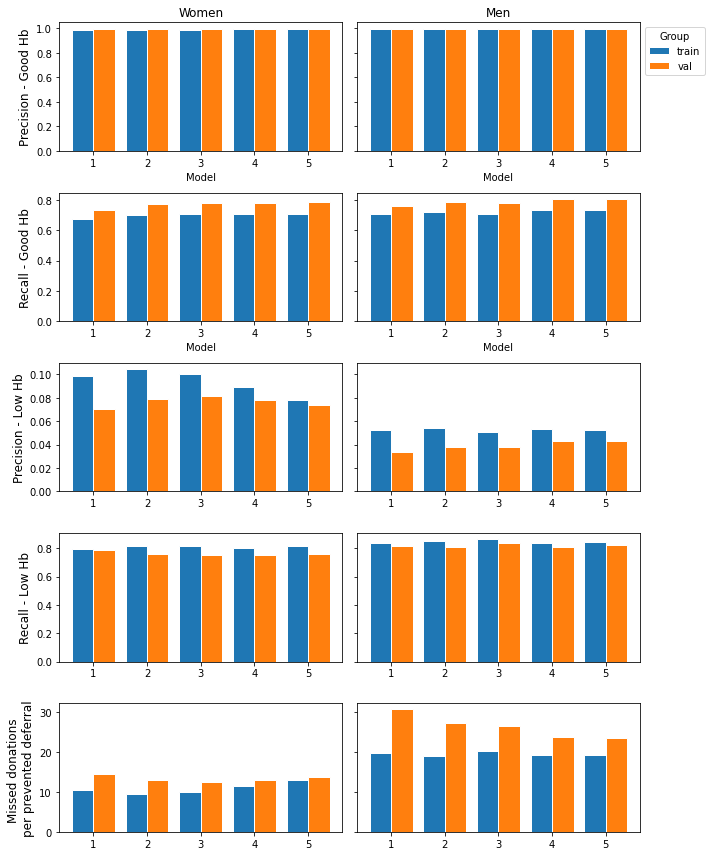

In [7]:
plot_precision_recall_all(res_df)

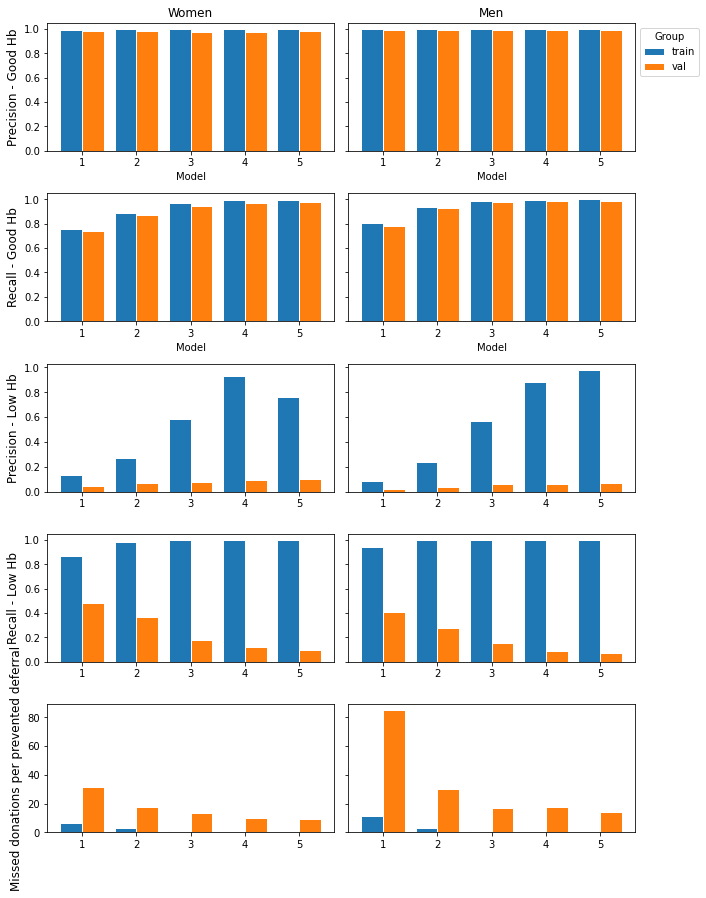

In [6]:
plot_precision_recall_all(res_df_noprs)

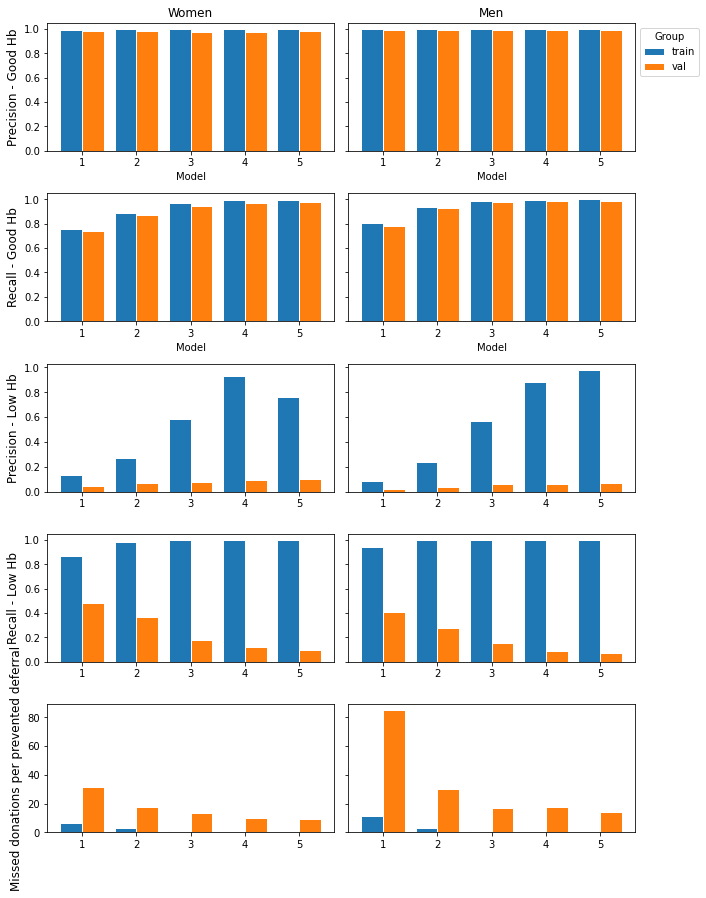

In [7]:
res_df_noprsb = pretty_results(['res_noprs_1', 'res_noprs_2', 'res_noprs_3', 'res_noprs_4', 'res_noprs_5'], filepath='../results/models_2012/')
res_df_noprsb = get_scores(res_df_noprsb)
plot_precision_recall_all(res_df_noprs)

In [16]:
def calc_shap(nback, n=100):
    filename = '../results/models/clf_' + str(nback) + '.sav'
    clf = pickle.load(open(filename, 'rb'))
    
    for index, sex in enumerate(['men', 'women']):
        val = pd.read_pickle('../../data/scaled/'+str(sex)+'_'+str(nback)+'_test.pkl')
        clf_s = clf[index]
        X_val = val[val.columns[:-1]]
        X_shap = shap.sample(X_val, n)
        explainer = shap.KernelExplainer(clf_s.predict, X_shap)
        shapvals = explainer.shap_values(X_shap)
        
        path = '../results/shap/'
        filename1 = 'Xshap' + sex + str(nback) + str(n) + '.pkl'
        filename2 = 'shapvals' + sex + str(nback) + str(n) + '.pkl'
        
        pickle.dump(X_shap, open(path+filename1, 'wb'))
        pickle.dump(shapvals, open(path+filename2, 'wb'))

In [17]:
calc_shap(1)

X does not have valid feature names, but SVC was fitted with feature names


  0%|          | 0/100 [00:00<?, ?it/s]

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprec

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a Sta

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVC was fitted with feature names


  0%|          | 0/100 [00:00<?, ?it/s]

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprec

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


Men 1


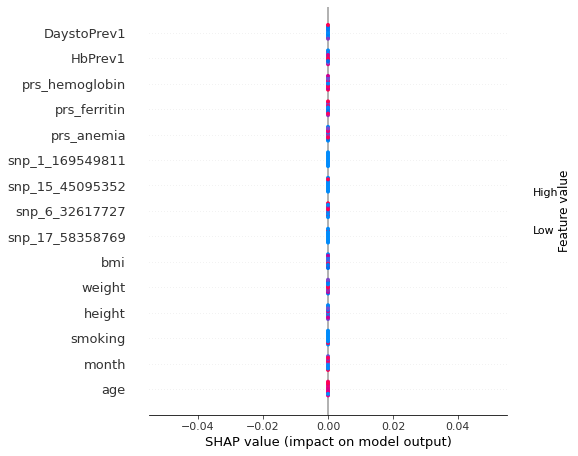

In [3]:
path = '../results/shap/'
sex = 'Men'
nback = 1
n = 10
filename1 = 'Xshap' + sex + str(nback) + str(n) + '.pkl'
filename2 = 'shapvals' + sex + str(nback) + str(n) + '.pkl'

# X_test = pd.read_pickle(path+filename1)
X_test = pickle.load(open(path+filename1, 'rb'))
shapvals = pickle.load(open(path+filename2, 'rb'))

print(sex, nback)
plt.figure(figsize=(8, 8))
fig = shap.summary_plot(shapvals, X_test)

In [72]:
n = 100
path = '../results/shap/'

for nback in range(1,6):
    for i, sex in enumerate(['M', 'F']):
        filename1 = 'Xshap' + sex + str(nback) + str(n) + '.pkl'
        filename2 = 'shapvals' + sex + str(nback) + str(n) + '.pkl'
        
        # X_test = pd.read_pickle(path+filename1)
        X_test = pickle.load(open(path+filename1, 'rb'))
        shapvals = pickle.load(open(path+filename2, 'rb'))
        
        print(sex, nback)
        plt.figure(figsize=(8, 8))
        fig = shap.summary_plot(shapvals, X_test, show=False)
        plt.savefig('X:/OneDrive/PhD/Research/202111 SVM prediction/plots/shapvals_'+sex+'_'+str(nback)+'.png', bbox_inches='tight')
        plt.close()

M 1
F 1
M 2
F 2
M 3
F 3
M 4
F 4
M 5
F 5


## Precision-recall curves

In [12]:
df = pd.read_csv('X:/OneDrive/PhD/Data/202111 SVM prediction/df_5f.csv')
df.head()

,KeyID,Sex,DoB,EIN,Date,Time,Center,DonType,BP_sys,BP_dia,...,TimetoPrev2,HbPrev3,TimetoPrev3,HbPrev4,TimetoPrev4,HbPrev5,TimetoPrev5,Last_Fer_Date,Last_Fer,TimetoFer
0,126,F,1998-04-02,N00111900515500Z,2019-01-17,20.166667,AL A'dam Valkenburgerstra,N,122.0,76.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,258,F,2000-08-09,N00112020843900S,2020-01-15,13.283333,AL Leiden,N,108.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,291,F,1969-08-21,N00182004960900D,2020-08-03,18.333333,AD490,N,115.0,75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,291,F,1969-08-21,N00182007094800N,2020-09-28,19.933333,AD490,V,105.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-03,40.0,56.0
4,291,F,1969-08-21,N00182102062500J,2021-02-15,18.516667,AD490,V,115.0,74.0,...,196.0,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-03,40.0,196.0


In [13]:
def prep_data_val(data, num_don, sex, scaler):
    var = ['KeyID', 'Year', 'Sex', 'Time', 'Age', 'Month', 'Last_Fer', 'TimetoFer']
    for n in range(1, num_don+1):
        var.extend(['HbPrev'+str(n), 'TimetoPrev'+str(n)])
    var.append('HbOK')
    Xy = data[var].copy()
    Xy = Xy.loc[Xy['Sex'] == sex, ].dropna()
    
    Xy_traintest = Xy.loc[Xy['Year'] != 2021, ]
    Xy_val = Xy.loc[Xy['Year'] == 2021, ]
    
    Xy_traintest = Xy_traintest[Xy_traintest.columns[3:]]
    Xy_val = Xy_val[Xy_val.columns[3:]]
    
    cols_to_scale = Xy_traintest.columns[:-1]
    Xy_val[cols_to_scale] = scaler.transform(Xy_val[cols_to_scale])
    
    return(Xy_val)

In [15]:
for nback in range(1,6):
    file_clf = 'X:/OneDrive/PhD/Data/202111 SVM prediction/trained_clfs_proba/clf_' + str(nback) + '.sav'
    file_scl = 'X:/OneDrive/PhD/Data/202111 SVM prediction/trained_clfs_proba/scaler_' + str(nback) + '.pkl'
    clfs = pickle.load(open(file_clf, 'rb'))
    scalers = pickle.load(open(file_scl, 'rb'))
    for index, sex in enumerate(['M', 'F']):
        print(datetime.datetime.now(), 'Starting', nback, sex)
        clf = clfs[index]
        scaler = scalers[index]
        df_val = prep_data_val(df, nback, sex, scaler)
        y_true = df_val[df_val.columns[-1:]].copy()
        y_pred = clf.predict_proba(df_val[df_val.columns[:-1]])
        y_true[['prob_low', 'prob_ok']] = y_pred
        file_preds = 'X:/OneDrive/PhD/Data/202111 SVM prediction/trained_clfs_proba/proba_' + sex + '_' + str(nback) + '.pkl'
        pickle.dump(y_true, open(file_preds, 'wb'))

2022-02-24 10:00:46.237659 Starting 1 M
2022-02-24 10:07:17.455185 Starting 1 F
2022-02-24 10:17:06.927179 Starting 2 M
2022-02-24 10:21:11.181393 Starting 2 F
2022-02-24 10:26:07.912168 Starting 3 M
2022-02-24 10:28:58.683689 Starting 3 F
2022-02-24 10:31:40.582031 Starting 4 M
2022-02-24 10:33:59.413445 Starting 4 F
2022-02-24 10:46:14.977795 Starting 5 M
2022-02-24 10:48:09.561612 Starting 5 F


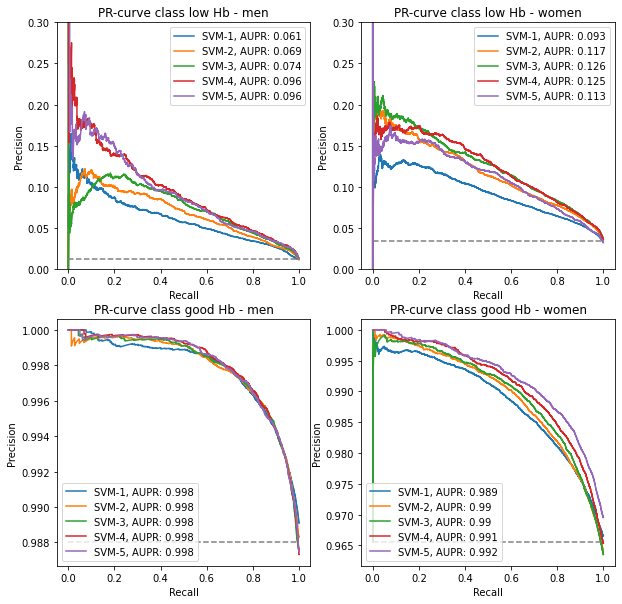

In [49]:
def load_probas(sexes = ['M', 'F'], nbacks = range(1, 6)):
    path = 'X:/OneDrive/PhD/Data/202111 SVM prediction/trained_clfs_proba/proba_'
    dfs = []
    for sex in sexes:
        for nback in nbacks:
            df = pd.read_pickle(path + sex + '_' + str(nback) + '.pkl')
            df['sex'] = sex
            df['nback'] = nback
            dfs.append(df)
    fulldf = pd.concat(dfs)
    return(fulldf)

def plot_prs(probas):
    fig, ax = plt.subplots(2, 2, figsize=(10,10))
    
    for x, sex in enumerate(['M', 'F']):
        df = probas.loc[probas['sex'] == sex, ]
        
        for key, group in df.groupby('nback'):
            precision_0, recall_0, thresholds_0 = precision_recall_curve(group.HbOK, group.prob_low, pos_label=0)
            precision_1, recall_1, thresholds_1 = precision_recall_curve(group.HbOK, group.prob_ok, pos_label=1)
            
            aupr_0 = round(average_precision_score(group.HbOK, group.prob_low, pos_label=0), 3)
            aupr_1 = round(average_precision_score(group.HbOK, group.prob_ok, pos_label=1), 3)

            ax[0,x].plot(recall_0, precision_0, label='SVM-'+str(key)+', AUPR: '+str(aupr_0))
            ax[1,x].plot(recall_1, precision_1, label='SVM-'+str(key)+', AUPR: '+str(aupr_1))
        
        ax[0,x].set_title('PR-curve class low Hb - ' + ['men', 'women'][x])
        ax[0,x].set_xlabel('Recall')
        ax[0,x].set_ylabel('Precision')
        ax[1,x].set_title('PR-curve class good Hb - ' + ['men', 'women'][x])
        ax[1,x].set_xlabel('Recall')
        ax[1,x].set_ylabel('Precision')
        ax[0,x].legend(loc='upper right')
        ax[1,x].legend(loc='lower left')
        ax[0,x].set_ylim(0,0.3)
    
    #horizontal lines for baseline
    ax[0,0].hlines(y=0.0119, xmin=0, xmax=1, color='grey', ls='--')
    ax[1,0].hlines(y=0.988, xmin=0, xmax=1, color='grey', ls='--')
    ax[0,1].hlines(y=0.0344, xmin=0, xmax=1, color='grey', ls='--')
    ax[1,1].hlines(y=0.9656, xmin=0, xmax=1, color='grey', ls='--')
    
    plt.show()

# probas = load_probas()
# probas.head()
plot_prs(probas)

In [42]:
for sex in ['M','F']:
    x = probas.loc[probas['sex']==sex, 'HbOK']
    print(sex, sum(x)/len(x), 1-(sum(x)/len(x)))

M 0.9880592304956288 0.011940769504371174
F 0.9655660168854705 0.0344339831145295
